# Modeling my Electricity usage

This is data from before and after fitting some home automation around the hot water based on meter readings.  Turns out my usage is actually pretty linear and it's not hard to beat the model that my electricity company uses to predict my bills (they are way out).  Also, TL;DR, putting a timer on the hot water (immersion heater) saved £54/month!

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt

Read meter readings from CSV, convert date to DateTimeIndex and calculate day of year for each entry

In [2]:
df = pd.read_csv('meter_readings.csv', delimiter=',')
df['date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', utc=True)
df.set_index('date', inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df['doy'] = df.index.dayofyear
df

,Outside Meter,Inside Meter,doy
date,,,
2019-02-07 00:00:00+00:00,2207,NaN,38
2019-02-20 00:00:00+00:00,2527,NaN,51
2019-03-06 00:00:00+00:00,2809,NaN,65
2019-03-24 00:00:00+00:00,3193,NaN,83
2019-04-08 00:00:00+00:00,3466,NaN,98
2019-04-10 00:00:00+00:00,3511,NaN,100
2019-04-15 00:00:00+00:00,3629,NaN,105
2019-04-18 00:00:00+00:00,3672,NaN,108
2019-04-23 00:00:00+00:00,3710,10.5,113


By plotting, it can be seen that there are two distinct piecewise linear relations (or a step change in gradient).

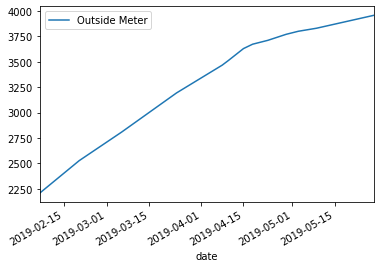

In [3]:
df.plot(y='Outside Meter')

The step change appears to be around 2019-04-15 so we will start with that as a guess and split the data in to two sets.  We will then perform a linear regression on both to get the gradients (m) and the intercepts (c) for each.  We will then solve the two linear equations to find the intersection (in days).

In [4]:
guess = '2019-04-15'
guess_dt = datetime.strptime(guess, '%Y-%m-%d')
step1 = df.loc[:guess]
step2 = df.loc[guess:]
step1_lin = np.polyfit(step1['doy'], step1['Outside Meter'], 1)
step2_lin = np.polyfit(step2['doy'], step2['Outside Meter'], 1)
print("Step 1", step1_lin)
print("Step 2", step2_lin)
# Solve functions of each step to find date of change
change = optimize.fsolve(lambda x: (step1_lin[0] * x + step1_lin[1]) - (step2_lin[0] * x + step2_lin[1]), 0.0)[0]
change_dt = datetime(2019, 1, 1, 0, 0) + timedelta(days=change)
print("Intersection: day {0:.2f} ({1})".format(change, change_dt.isoformat()))

Step 1 [  20.76497441 1446.98768848]
Step 2 [   7.43263904 2869.20285841]
Intersection: day 106.67 (2019-04-17T16:10:44.144485)


Now that we have the two sets of gradient and intercept and the step change, we can write a function (named f to be original) that should be able to predict a meter reading for a given day and add this to the data frame.  Plotting this shows that f() is reasonably accurate.

MSE1: 229.65


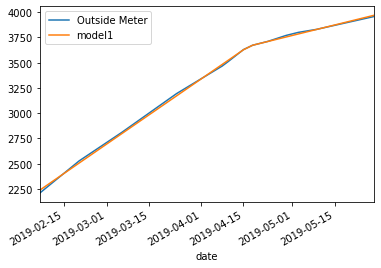

In [5]:
def f(x, m1, c1, m2, c2, change):
    return (x.doy * m1 + c1) if x.doy < change else (x.doy * m2 + c2)
    
df['model1'] = df.apply(lambda x: f(x, *step1_lin, *step2_lin, change), axis=1)
df.plot(y=['Outside Meter', 'model1'])
mse1 = mean_squared_error(y_true=df['Outside Meter'], y_pred=df['model1'])
print("MSE1: {0:.2f}".format(mse1))

Now that we have a better guess of the step change, re-run the regression and see if the model improves (lower MSE).

Step 1 [  20.76497441 1446.98768848]
Step 2 [   7.05492676 2919.22569907]
MSE2: 213.20


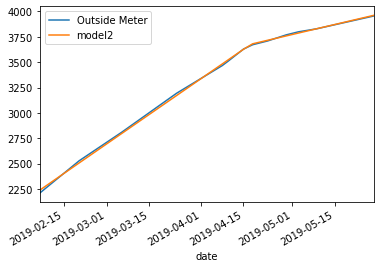

In [6]:
step1 = df.loc[:change_dt]
step2 = df.loc[change_dt:]
step1_lin = np.polyfit(step1['doy'], step1['Outside Meter'], 1)
step2_lin = np.polyfit(step2['doy'], step2['Outside Meter'], 1)
print("Step 1", step1_lin)
print("Step 2", step2_lin)
df['model2'] = df.apply(lambda x: f(x, *step1_lin, *step2_lin, change), axis=1)
mse2 = mean_squared_error(y_true=df['Outside Meter'], y_pred=df['model2'])
print("MSE2: {0:.2f}".format(mse2))
df.plot(y=['Outside Meter', 'model2'])

This has reduced the MSE (and the second step appears a better fit), so we'll go with the updated model.

By plugging in the daily standing charge and kWh unit cost, we can calculate the before and after daily and montly costs:

In [7]:
rate = 0.1301
sc = 0.2044
step1_cost_pd = rate * step1_lin[0] + sc
step1_cost_pm = step1_cost_pd * (365 / 12)
step2_cost_pd = rate * step2_lin[0] + sc
step2_cost_pm = step2_cost_pd * (365 / 12)

print("Step 1: £{0:.2f}/day (£{1:.2f}/mon)".format(step1_cost_pd, step1_cost_pm))
print("Step 2: £{0:.2f}/day (£{1:.2f}/mon)".format(step2_cost_pd, step2_cost_pm))

Step 1: £2.91/day (£88.39/mon)
Step 2: £1.12/day (£34.13/mon)
